## Covariance shrinkage (for better generalization)

In [2]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import root_scalar
from sklearn.covariance import LedoitWolf

In [3]:
df = pd.read_csv('_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.loc['2022-01-01':'2024-01-01']
returns = df.pct_change().dropna()

In [4]:
#parameters
r=0.05  # risk-free rate
portfolio_value = 1000000  # initial portfolio value
n=len(df.columns)  # number of assets
volatility_target = 0.25  # target annualized volatility
x_max=0.07  # maximum weight per asset
TRADING_DAYS = 365 # number of trading days in a year

# backtest parameters
rebalance_frequency = 30 # monthly rebalancing
window_size = 90  # 3 months rolling window

In [5]:
#fees parameters
c_fee = 0.001  # 0.1% per trade (buy or sell)

total_fees = 0.0
fees_list = []          
fees_dates = []        


In [6]:
#compute rolling statistics
rolling_mean = returns.rolling(window=window_size).mean().shift(1) 
#rolling_cov = returns.rolling(window=window_size).cov().shift(1) # not used anymore with LedoitWolf


In [7]:


def optimize_target_vol(mu_daily, Sigma_daily, r_annual=r, target_vol_annual=volatility_target, w_max=x_max):
    mu_daily = np.asarray(mu_daily).reshape(-1)
    n = mu_daily.shape[0]
    Sigma_daily = np.asarray(Sigma_daily)

    # Consistent annualization
    Sigma_ann = TRADING_DAYS * Sigma_daily
    mu_ann = TRADING_DAYS * mu_daily

    
    Sigma_ann = Sigma_ann + 1e-10 * np.eye(n)

    w = cp.Variable(n)  # risky weights
    w_cash = 1 - cp.sum(w) # cash weight

    # objective: expected annual return risky + cash
    objective = cp.Maximize(mu_ann @ w + r_annual * w_cash)

    constraints = [
        w >= 0,
        w <= w_max,
        cp.sum(w) <= 1,   # the rest in cash
        cp.quad_form(w, Sigma_ann) <= target_vol_annual**2
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.ECOS, verbose=False) 

    if w.value is None:
        raise RuntimeError("Optimization failed (infeasible/solver).")

    w_risky = np.array(w.value).reshape(-1)
    w0 = float(1 - w_risky.sum())
    return w0, w_risky


In [8]:
# rebalance dates (every 30 days starting from window_size)
rebalance_dates = returns.index[window_size::rebalance_frequency]

portfolio_values = []
weights_history = []

V = portfolio_value

# initialize weights (before first optimization)
w0 = 1.0
w_risky = np.zeros(n)

for t in returns.index[window_size:]:  # start when we have lookback data
    # 1) if it's a rebalance date, calculate new weights
    if t in rebalance_dates:
        mu = rolling_mean.loc[t].values
        
        #old Sigma
        """
        Sigma = rolling_cov.loc[t].values  # must be (n,n)

        # Cleaning + symmetrization
        Sigma = np.asarray(Sigma, dtype=float)
        Sigma = np.nan_to_num(Sigma, nan=0.0, posinf=0.0, neginf=0.0)
        Sigma = 0.5 * (Sigma + Sigma.T)  # <-- symmetrization
        # Shift diagonal if min eigenvalue < 0
        eig_min = np.linalg.eigvalsh(Sigma).min()
        if eig_min < 0:
            Sigma = Sigma + (-eig_min + 1e-10) * np.eye(Sigma.shape[0])
        """
        # COVARIANCE SHRINKAGE (Ledoit–Wolf)
        # Returns window that stops at t-1 (no lookahead)
        idx = returns.index.get_loc(t)
        window_ret = returns.iloc[idx-window_size:idx] 

        # LedoitWolf doesn't accept NaN/inf 
        X = window_ret.replace([np.inf, -np.inf], np.nan)
        X = X.apply(lambda col: col.fillna(col.mean()), axis=0).fillna(0.0)

        lw = LedoitWolf().fit(X.values)
     
        Sigma = lw.covariance_  # shrunk covariance (much more stable)
        Sigma = 0.5 * (Sigma + Sigma.T)  # numerical safety
        
        w0_target, w_risky_target = optimize_target_vol(
            mu, Sigma,
            r_annual=r,
            target_vol_annual=volatility_target,
            w_max=x_max
        )
        
        V_before = V
        s_old = V_before * w_risky              # risky dollars before
        s_new = V_before * w_risky_target       # target risky dollars after
        traded_notional = np.sum(np.abs(s_new - s_old))
        fee_t = c_fee * traded_notional

        total_fees += fee_t
        fees_list.append(fee_t)
        fees_dates.append(t)

        # pay fees in cash 
        V = V_before - fee_t

        # 2) Effective weights after paying fees
        w_risky = s_new / V
        w0 = 1.0 - w_risky.sum()

        # numerical safety (just in case)
        w_risky = np.clip(w_risky, 0.0, 1.0)
        w0 = max(0.0, 1.0 - w_risky.sum())
        weights_history.append((t, w0, w_risky.copy()))

    # 3) apply the daily return with current weights 
    daily_rf = r / TRADING_DAYS
    port_ret = w0 * daily_rf + float(np.dot(w_risky, returns.loc[t].values))
    V = V * (1 + port_ret)

    portfolio_values.append((t, V))

portfolio_values = pd.Series(
    [v for _, v in portfolio_values],
    index=[d for d, _ in portfolio_values],
    name="V"
)


In [9]:
#computation of the performance metrics
def annualized_return(portfolio_values,initial_value):
    T=len(portfolio_values.index)-1
    return TRADING_DAYS/T*(portfolio_values.iloc[-1]- initial_value)/initial_value

print("Annualized Return:", annualized_return(portfolio_values, portfolio_value))

Annualized Return: 0.21487201713828769


In [10]:
def portfolio_daily_returns(portfolio_values):
    return portfolio_values.pct_change().dropna()

In [11]:
def annualized_volatility(portfolio_values):
    r = portfolio_daily_returns(portfolio_values)
    return np.sqrt(TRADING_DAYS) * r.std(ddof=1) 

print("Annualized Volatility:", annualized_volatility(portfolio_values))

Annualized Volatility: 0.22853724865364303


In [12]:
def sharpe_ratio(portfolio_values, r_annual=0.05):
    r = portfolio_daily_returns(portfolio_values)
    r_daily_rf = r_annual / TRADING_DAYS
    excess_mean = (r - r_daily_rf).mean()
    vol_daily = r.std(ddof=1)
    return np.sqrt(TRADING_DAYS) * excess_mean / vol_daily 

print("Sharpe Ratio:", sharpe_ratio(portfolio_values, r_annual=r))

Sharpe Ratio: 0.6472025472306753


In [13]:
def max_drawdown(portfolio_values):
    V = portfolio_values.values
    running_max = np.maximum.accumulate(V)
    drawdowns = 1.0 - (V / running_max)
    return np.max(drawdowns)

print("Maximum Drawdown:", max_drawdown(portfolio_values))

Maximum Drawdown: 0.24000949146017425


In [14]:
def diversification_D(w_risky):
    w = np.array(w_risky, dtype=float)
    s = w.sum()
    H = (w @ w) / (s * s)
    n = len(w)
    return (1.0 / n) * (1.0 / H)

In [15]:
def average_diversification(weights_history):
    Ds = []
    for w_full in weights_history:
        w_full = np.asarray(w_full).reshape(-1)
        w_risky = w_full[1:]  # exclude cash
        Ds.append(diversification_D(w_risky))
    return float(np.mean(Ds)) if len(Ds) > 0 else np.nan

print("Average Diversification D:", average_diversification([np.hstack(([w0], w_risky)) for _, w0, w_risky in weights_history]))

Average Diversification D: 0.22338468122965646


In [16]:
# Asset allocation analysis
print("="*80)
print("ASSET ALLOCATION ANALYSIS")
print("="*80)

# Get asset names
asset_names = df.columns.tolist()

# Create a matrix of all weights over time
weights_matrix = np.array([w_risky for _, _, w_risky in weights_history])

# Calculate statistics for each asset
print(f"\n{'Asset':<20} {'Average':<12} {'Min':<12} {'Max':<12} {'Count >0':<12}")
print("-"*80)

for i, asset_name in enumerate(asset_names):
    weights_asset = weights_matrix[:, i]
    mean_weight = weights_asset.mean()
    min_weight = weights_asset.min()
    max_weight = weights_asset.max()
    nb_nonzero = np.sum(weights_asset > 0.001)  # number of times weight > 0.1%
    
    print(f"{asset_name:<20} {mean_weight:>10.2%}  {min_weight:>10.2%}  {max_weight:>10.2%}  {nb_nonzero:>10}")

print("\n" + "="*80)
print(f"Average cash allocation: {np.mean([w0 for _, w0, _ in weights_history]):.2%}")
print(f"Average risky assets allocation: {(1 - np.mean([w0 for _, w0, _ in weights_history])):.2%}")

ASSET ALLOCATION ANALYSIS

Asset                Average      Min          Max          Count >0    
--------------------------------------------------------------------------------
bitcoin                   2.43%       0.00%       7.00%          10
ethereum                  0.86%       0.00%       7.00%           3
solana                    1.97%       0.00%       7.00%           7
polkadot                  0.00%       0.00%       0.00%           0
avalanche-2               0.34%       0.00%       7.00%           2
tron                      3.17%       0.00%       7.00%          11
thorchain                 2.27%       0.00%       7.00%           8
ripple                    3.03%       0.00%       7.00%          10
vechain                   0.35%       0.00%       5.11%           2
matic-network             1.51%       0.00%       7.00%           5
chainlink                 2.21%       0.00%       7.00%           7
the-graph                 0.58%       0.00%       7.00%           3
arw

In [17]:
#Performance summary

print("\n" + "="*100)
print(" "*35 + "PERFORMANCE SUMMARY")
print("="*100)

# Calculation of all metrics
ann_return = annualized_return(portfolio_values, portfolio_value)
ann_vol = annualized_volatility(portfolio_values)
sharpe = sharpe_ratio(portfolio_values, r_annual=r)
mdd = max_drawdown(portfolio_values)
avg_div = average_diversification([np.hstack(([w0], w_risky)) for _, w0, w_risky in weights_history])
avg_cash = np.mean([w0 for _, w0, _ in weights_history])
avg_risky = 1 - avg_cash
fee_cost = total_fees / portfolio_value


# Formatted display
print(f"\n{'Metric':<40} {'Value':>20}")
print("-"*100)
print(f"{'Annualized return':<40} {ann_return:>19.2%}")
print(f"{'Annualized volatility':<40} {ann_vol:>19.2%}")
print(f"{'Sharpe ratio':<40} {sharpe:>20.4f}")
print(f"{'Maximum drawdown':<40} {mdd:>19.2%}")
print(f"{'Average diversification (D)':<40} {avg_div:>20.4f}")
print(f"{"Total Fees ($)":<40} {total_fees:>20.4f}")
print(f"{"Fee cost":<40} {fee_cost:>19.2%}")

print("-"*100)
print(f"{'Average cash allocation':<40} {avg_cash:>19.2%}")
print(f"{'Average risky assets allocation':<40} {avg_risky:>19.2%}")
print("-"*100)
print(f"{'Initial portfolio value':<40} {portfolio_value:>20,.0f}")
print(f"{'Final portfolio value':<40} {portfolio_values.iloc[-1]:>20,.2f}")
print(f"{'Total gain':<40} {(portfolio_values.iloc[-1] - portfolio_value):>20,.2f}")
print("="*100 + "\n")


                                   PERFORMANCE SUMMARY

Metric                                                  Value
----------------------------------------------------------------------------------------------------
Annualized return                                     21.49%
Annualized volatility                                 22.85%
Sharpe ratio                                           0.6472
Maximum drawdown                                      24.00%
Average diversification (D)                            0.2234
Total Fees ($)                                      4257.2246
Fee cost                                               0.43%
----------------------------------------------------------------------------------------------------
Average cash allocation                               71.05%
Average risky assets allocation                       28.95%
----------------------------------------------------------------------------------------------------
Initial portfolio value   

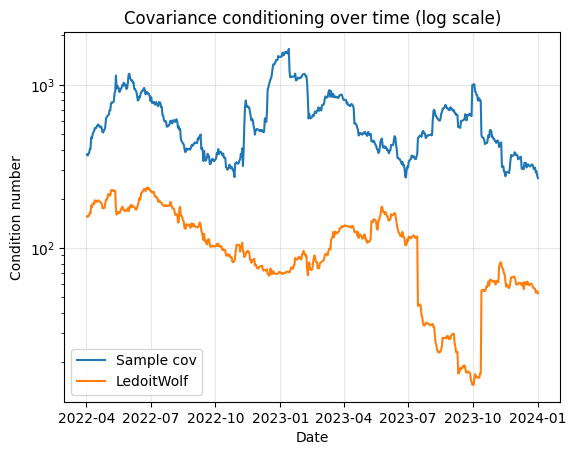

In [18]:
#Sample vs LedoitWolf conditioning over time

from sklearn.covariance import LedoitWolf

cond_sample, cond_lw, dates = [], [], []

for t in returns.index[window_size:]:
    idx = returns.index.get_loc(t)
    X = returns.iloc[idx-window_size:idx].replace([np.inf, -np.inf], np.nan)
    X = X.apply(lambda col: col.fillna(col.mean()), axis=0).fillna(0.0)

    S = np.cov(X.values, rowvar=False, ddof=1)
    lw = LedoitWolf().fit(X.values)
    Sigma_lw = lw.covariance_

    cond_sample.append(np.linalg.cond(S + 1e-12*np.eye(S.shape[0])))
    cond_lw.append(np.linalg.cond(Sigma_lw + 1e-12*np.eye(Sigma_lw.shape[0])))
    dates.append(t)

cond_df = pd.DataFrame({"cond_sample": cond_sample, "cond_lw": cond_lw}, index=dates)

plt.figure()
plt.plot(cond_df.index, cond_df["cond_sample"], label="Sample cov")
plt.plot(cond_df.index, cond_df["cond_lw"], label="LedoitWolf")
plt.yscale("log")
plt.title("Covariance conditioning over time (log scale)")
plt.ylabel("Condition number")
plt.xlabel("Date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()